In [9]:
import math
from tqdm import tqdm
import torch
from torch import Tensor, nn
import torch.nn.functional as F
import numpy as np
import matplotlib.pyplot as plt
from torch.optim.lr_scheduler import CosineAnnealingLR

from typing import Union, Tuple, List, Optional, Callable, Any
from torchvision import datasets, transforms, utils
from torch.utils.data import DataLoader

import sys
from pathlib import Path
# Go up one level from training_scripts/ to the project root
project_root = Path().resolve().parent
sys.path.append(str(project_root))

%load_ext autoreload
%autoreload 2

from datasets.gaussian_mixture import generate_samples

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

import torch
import random
import torch.backends.cudnn as cudnn

torch.manual_seed(42)
torch.cuda.manual_seed(42)
torch.cuda.manual_seed_all(42)
np.random.seed(42)
cudnn.benchmark = False
cudnn.deterministic = True
random.seed(42)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
Using device: cuda


## Dataset

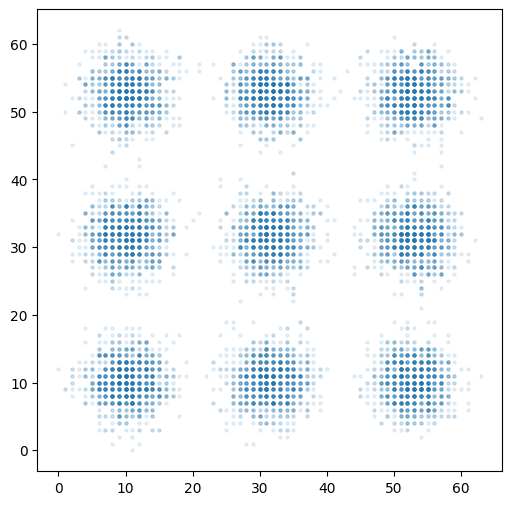

In [10]:
# Visulize dataset
samples = generate_samples(type="1", n_grid_points=64, batch_size=10000)
plt.figure(figsize=(6, 6))
plt.scatter(samples[:, 0], samples[:, 1], s=5, alpha=0.1)
plt.show()

## Training

In [ ]:
from models.discrete_diffusion.udm import UniformDiffusion
from models.discrete_diffusion.utils.parametrizations import subs_parametrization
from models.denoising_models.mlp import MLP

batch_size = 64
train_steps = 100000
vocab_size = 64
num_categories = vocab_size
input_shape = (2,)
num_timesteps = 100
lr = 1e-3

model = UniformDiffusion(
    denoising_model=MLP(
        input_shape=input_shape,
        num_categories=num_categories,
        embed_dim=64,
        hidden_dim=64,
        encode_time=True,
        n_hidden_layers=2,
    ),
    num_categories=num_categories,
    input_shape=input_shape,
    noise_schedule="linear",
    num_timesteps=num_timesteps,
    discretization_schedule="linear",
).to(device)

optimizer = torch.optim.Adam(model.parameters(), lr=lr)
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=train_steps, eta_min=lr * 0.01)

In [ ]:
# model.load_state_dict(torch.load('../model_weights/mdm_checkerboard_256.pth'))

Step 100/10000, Loss (EWMA): 7.1971, LR: 0.001000
Step 200/10000, Loss (EWMA): 7.1960, LR: 0.000999
Step 300/10000, Loss (EWMA): 7.0813, LR: 0.000998
Step 400/10000, Loss (EWMA): 7.0269, LR: 0.000996
Step 500/10000, Loss (EWMA): 6.9956, LR: 0.000994
Step 600/10000, Loss (EWMA): 7.2144, LR: 0.000991
Step 700/10000, Loss (EWMA): 7.0904, LR: 0.000988
Step 800/10000, Loss (EWMA): 7.1182, LR: 0.000984
Step 900/10000, Loss (EWMA): 6.9976, LR: 0.000980
Step 1000/10000, Loss (EWMA): 7.2414, LR: 0.000976
Step 1100/10000, Loss (EWMA): 7.6002, LR: 0.000970
Step 1200/10000, Loss (EWMA): 7.3341, LR: 0.000965
Step 1300/10000, Loss (EWMA): 7.3787, LR: 0.000959
Step 1400/10000, Loss (EWMA): 7.3622, LR: 0.000952
Step 1500/10000, Loss (EWMA): 7.4949, LR: 0.000946
Step 1600/10000, Loss (EWMA): 7.3912, LR: 0.000938
Step 1700/10000, Loss (EWMA): 7.2211, LR: 0.000930
Step 1800/10000, Loss (EWMA): 7.1473, LR: 0.000922
Step 1900/10000, Loss (EWMA): 7.0100, LR: 0.000914
Step 2000/10000, Loss (EWMA): 6.9344, LR

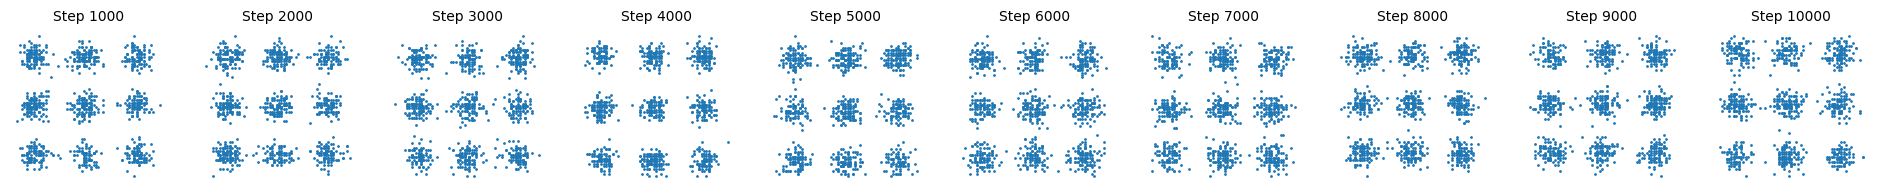

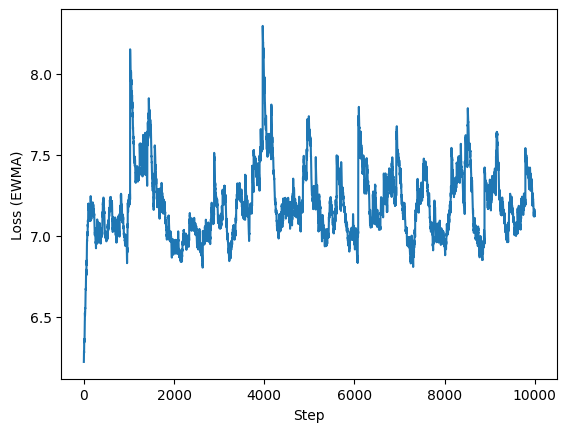

In [23]:
fig, ax = plt.subplots(nrows=1, ncols=10, figsize=(24, 2))
fig_idx = 0

losses = []
loss_ewma = None

for step in range(train_steps):
    x = generate_samples(type="1", n_grid_points=vocab_size, batch_size=batch_size, device=device)
    
    model.train()
    optimizer.zero_grad()
    loss = model(x)
    loss.backward()
    optimizer.step()
    scheduler.step()
    
    if loss_ewma is None:
        loss_ewma = loss.item()
    else:
        loss_ewma = 0.99 * loss_ewma + 0.01 * loss.item()
    losses.append(loss_ewma)
    
    if (step + 1) % 100 == 0:
        print(f"Step {step + 1}/{train_steps}, Loss (EWMA): {loss_ewma:.4f}, LR: {optimizer.param_groups[0]['lr']:.6f}")
        
    if (step + 1) % (train_steps // 10) == 0:
        model.eval()
        with torch.no_grad():
            samples = model.sample(num_samples=1000, device=device).cpu().numpy()
        ax[fig_idx].scatter(samples[:, 0], samples[:, 1], s=1)
        ax[fig_idx].set_title(f"Step {step + 1}", fontsize=10)
        ax[fig_idx].axis('off')
        fig_idx += 1
        
plt.show()

plt.plot(losses)
plt.xlabel('Step')
plt.ylabel('Loss (EWMA)')
plt.show()

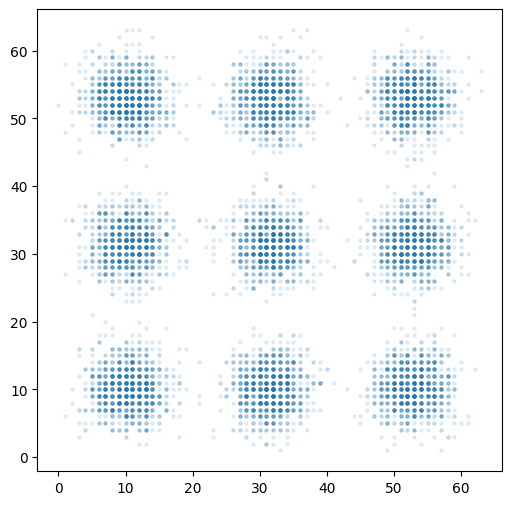

In [14]:
# Visualize model samples
model.eval()
with torch.no_grad():
    samples = model.sample(num_samples=10000, device=device).cpu().numpy()
plt.figure(figsize=(6, 6))
plt.scatter(samples[:, 0], samples[:, 1], s=5, alpha=0.1)
plt.show()

In [ ]:
# store model weights
torch.save(model.state_dict(), '../model_weights/udm_gmm_type1_64.pth')

z_t


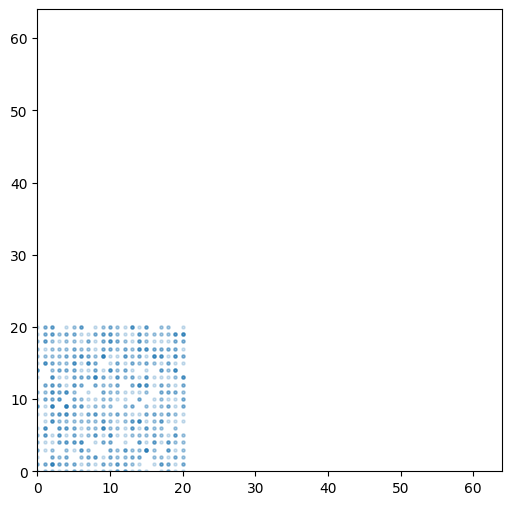

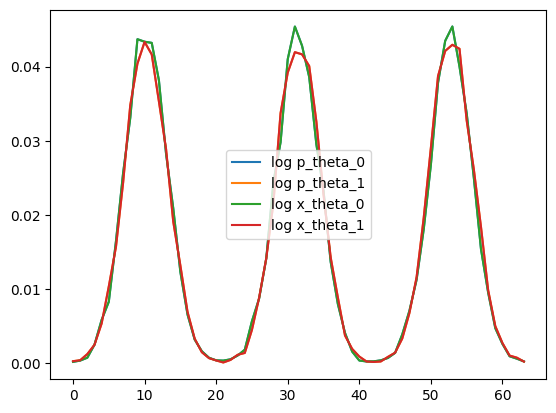

z_s


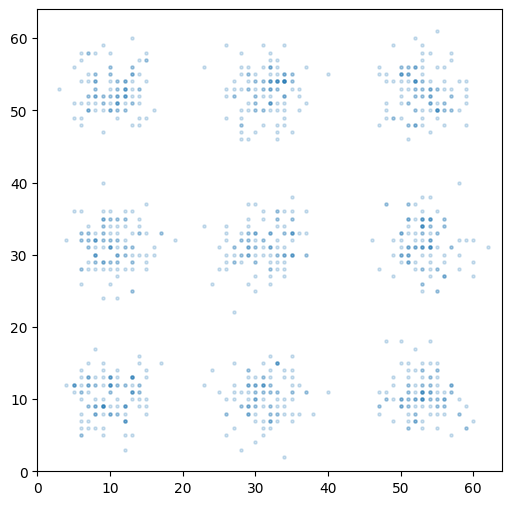

x_0


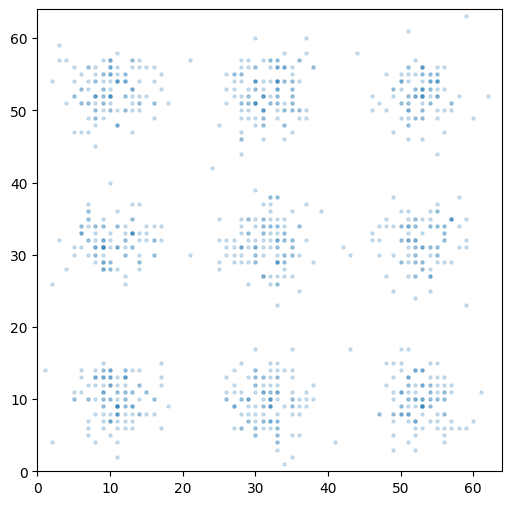

In [24]:
def plot(samples):
    plt.figure(figsize=(6, 6))
    plt.scatter(samples[:, 0], samples[:, 1], s=5, alpha=0.2)
    plt.xlim(0, num_categories)
    plt.ylim(0, num_categories)
    plt.show()

points = torch.randint(0, vocab_size//3, (1000, 2)) + torch.tensor([0 * vocab_size//3, 0 * vocab_size//3])

print("z_t")
plot(points)

p_theta, x_theta = model.sample_step(F.one_hot(points, num_classes=num_categories).float().to(device), 1, device=device)
p_theta, x_theta = p_theta.detach().cpu(), x_theta.detach().cpu()

# lets look at the probability distribution of a single point
r = 200
plt.plot(torch.arange(num_categories), p_theta[r, 0, :].cpu(), label="log p_theta_0")
plt.plot(torch.arange(num_categories), p_theta[r, 1, :].cpu(), label="log p_theta_1")
plt.plot(torch.arange(num_categories), x_theta[r, 0, :].cpu(), label="log x_theta_0")
plt.plot(torch.arange(num_categories), x_theta[r, 1, :].cpu(), label="log x_theta_1")
# plt.yscale('log')
# plt.ylim(0, 0.02)
# plt.axhline(y=1/128, color='k', linestyle='--')
plt.legend()
plt.show()

print("z_s")
z_s = torch.distributions.Categorical(probs=p_theta).sample().cpu() # Shape: (B, L)
plot(z_s)

print("x_0")
x_0 = torch.distributions.Categorical(probs=x_theta).sample().cpu() # Shape: (B, L)
plot(x_0)